Initial Data:
   step                                              state    move  score
0     0  [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...    drop    829
1     1  [1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, ...   right     90
2     2  [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...  rotate    216
3     3  [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, ...    drop    946
4     4  [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...   right    929

Processed Data:
   step    move  score  0  1  2  3  4  5  6  ...  190  191  192  193  194  \
0     0    drop    829  0  1  0  0  1  1  0  ...    0    1    1    1    0   
1     1   right     90  1  0  1  0  0  0  1  ...    1    0    0    0    0   
2     2  rotate    216  1  0  0  1  1  1  1  ...    0    0    1    0    0   
3     3    drop    946  0  1  0  0  0  0  1  ...    0    1    1    0    0   
4     4   right    929  1  1  0  1  0  0  0  ...    1    1    1    0    1   

   195  196  197  198  199  
0    1    1    1    1    0  
1   

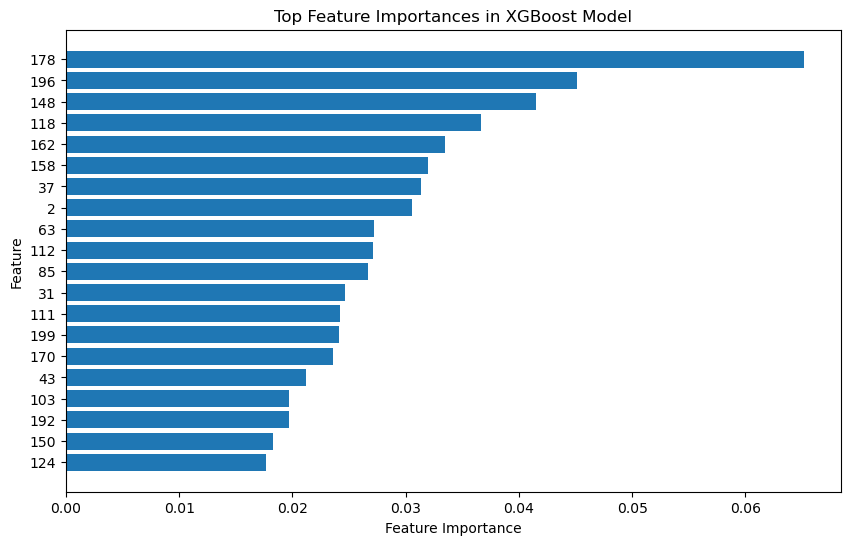

Training Decision Tree model...
Plotting Decision Tree...


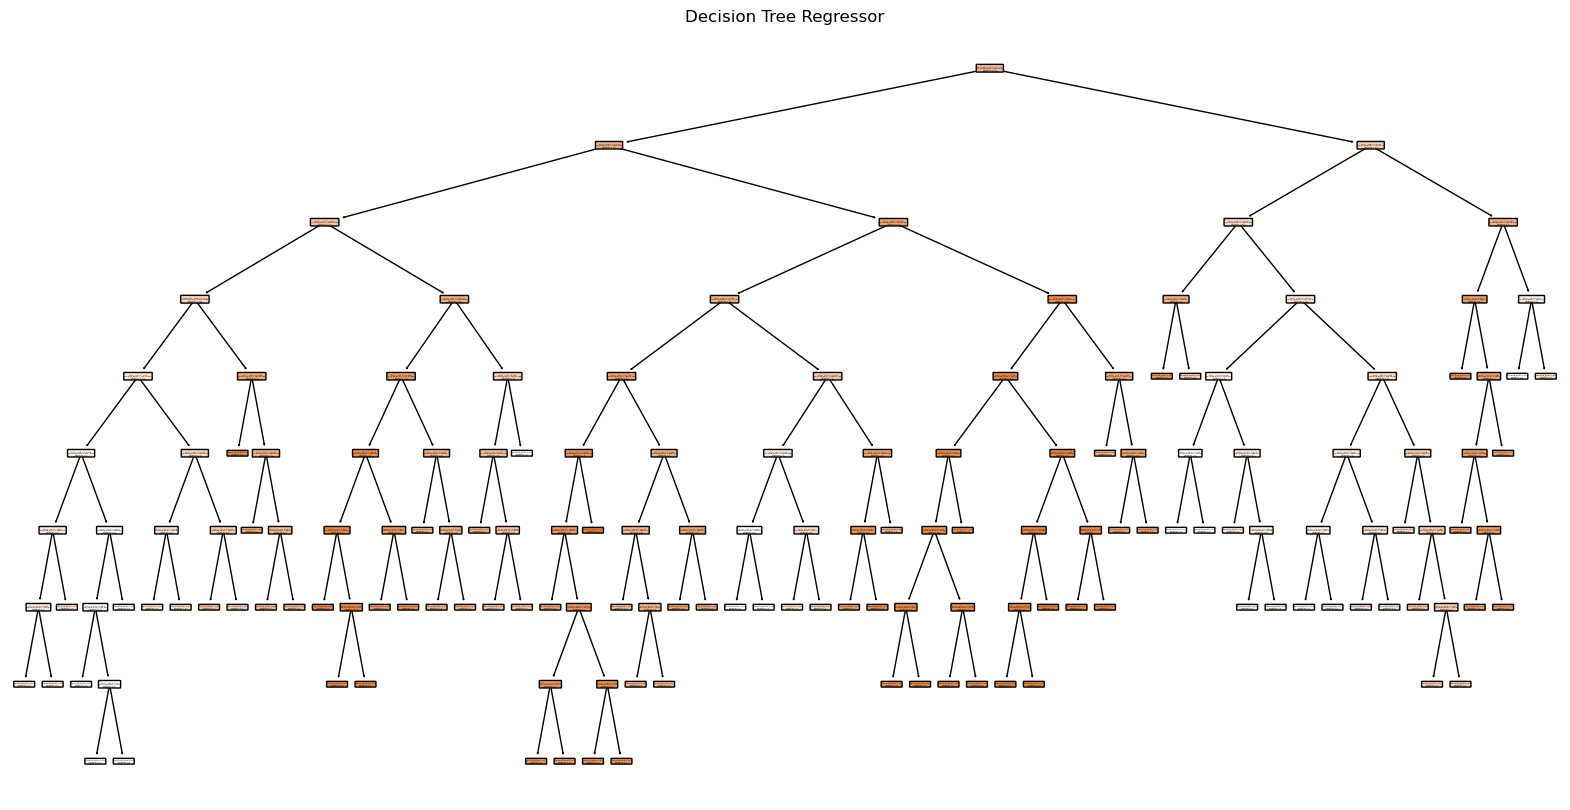


Predicted vs Actual Scores:
    step    move  0  1  2  3  4  5  6  7  ...  192  193  194  195  196  197  \
83    83    left  1  1  0  0  0  1  1  1  ...    1    1    1    0    0    0   
53    53    drop  1  0  0  1  0  0  1  1  ...    0    0    0    0    0    0   
70    70    drop  1  1  1  1  1  0  0  1  ...    1    0    0    1    0    1   
45    45    left  0  0  1  0  1  0  1  1  ...    1    0    0    0    1    1   
44    44  rotate  1  0  1  0  0  0  1  1  ...    1    0    1    0    1    0   

    198  199  Actual_Score  Predicted_Score  
83    0    0           168       453.766205  
53    0    1           736       618.166565  
70    1    1           417       606.584595  
45    1    0           922       174.149246  
44    1    1           535       431.012299  

[5 rows x 204 columns]


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

#load the data
def load_data(file_path):
    """Load the CSV file into a DataFrame."""
    try:
        data = pd.read_csv(file_path)
        print("Initial Data:")
        print(data.head())
        return data
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return None

#Preprocess the data
def preprocess_data(data):
    """Preprocess the data: Convert 'state' to individual columns, one-hot encode 'move'."""
    data['state'] = data['state'].apply(lambda x: list(map(int, x.strip('[]').split(','))))
    state_df = pd.DataFrame(data['state'].tolist(), index=data.index)
    data = data.drop(columns=['state']).join(state_df)
    data.columns = data.columns.astype(str)
    print("\nProcessed Data:")
    print(data.head())
    return data

#Define the preprocessor
def define_preprocessor(feature_columns):
    """Define a ColumnTransformer for preprocessing."""
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), feature_columns[2:]),  # Scale numerical features
            ('cat', OneHotEncoder(), ['move'])  # One-hot encode the 'move' column
        ],
        remainder='passthrough'
    )
    return preprocessor


#train the model
def train_model(X_train, y_train, preprocessor):
    """Train the model using GridSearchCV and cross-validation."""
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42))
    ])
    
    param_grid = {
        'regressor__n_estimators': [100],
        'regressor__learning_rate': [0.1, 0.2],
        'regressor__max_depth': [3, 5],
        'regressor__min_child_weight': [1, 3],
        'regressor__subsample': [0.8, 1.0],
        'regressor__colsample_bytree': [0.8, 1.0]
    }

    print("Starting Grid Search...")
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3)
    grid_search.fit(X_train, y_train)
    print("Grid Search Completed.")
    
    best_model = grid_search.best_estimator_
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)
    print(f"\nCross-Validation Mean Squared Error: {cv_mse}")
    return best_model

#evaluate the model
def evaluate_model(model, X_test, y_test):
    """Evaluate the model performance on the test set."""
    print("Evaluating the model on test set...")
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Test Mean Squared Error: {mse}")
    print(f"Test R^2 Score: {r2}")
    return y_pred

#plot feauture importances
def plot_feature_importances(model, features):
    """Plot the top feature importances."""
    feature_importances = model.named_steps['regressor'].feature_importances_
    preprocessor = model.named_steps['preprocessor']

    num_features = features.columns[2:]
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
    all_features = np.concatenate((cat_features, num_features))

    # Fix mismatch by checking lengths and slicing if necessary
    min_length = min(len(feature_importances), len(all_features))
    feature_importances = feature_importances[:min_length]
    all_features = all_features[:min_length]

    sorted_idx = np.argsort(feature_importances)[::-1]
    sorted_features = [all_features[i] for i in sorted_idx]
    sorted_importances = feature_importances[sorted_idx]

    top_n = 20
    sorted_features = sorted_features[:top_n]
    sorted_importances = sorted_importances[:top_n]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Top Feature Importances in XGBoost Model")
    plt.gca().invert_yaxis()
    plt.show()

#Train the decision tree
def train_decision_tree(X_train, y_train):
    """Train a Decision Tree model."""
    print("Training Decision Tree model...")
    tree_model = DecisionTreeRegressor(random_state=42)
    tree_model.fit(X_train, y_train)
    return tree_model

#plot the decision tree
def plot_decision_tree(tree_model, feature_names):
    """Plot the Decision Tree."""
    print("Plotting Decision Tree...")
    plt.figure(figsize=(20, 10))
    plot_tree(tree_model, feature_names=feature_names, filled=True, rounded=True)
    plt.title("Decision Tree Regressor")
    plt.show()

#main
def main():
    file_path = 'tetris_data.csv'  
    data = load_data(file_path)
    if data is None:
        return

    data = preprocess_data(data)
    
    features = data.drop(columns=['score'])
    labels = data['score']
    
    preprocessor = define_preprocessor(features.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    print("Data split into training and testing sets.")
    
    best_model = train_model(X_train, y_train, preprocessor)
    
    y_pred = evaluate_model(best_model, X_test, y_test)
    
    plot_feature_importances(best_model, features)
    
    # Train and plot the decision tree
    X_train_transformed = preprocessor.fit_transform(X_train)
    decision_tree_model = train_decision_tree(X_train_transformed, y_train)
    feature_names = preprocessor.get_feature_names_out()
    plot_decision_tree(decision_tree_model, feature_names)

    # Combine predictions with actual scores
    results_df = X_test.copy()
    results_df['Actual_Score'] = y_test
    results_df['Predicted_Score'] = y_pred
    print("\nPredicted vs Actual Scores:")
    print(results_df.head())

    

if __name__ == "__main__":
    main()

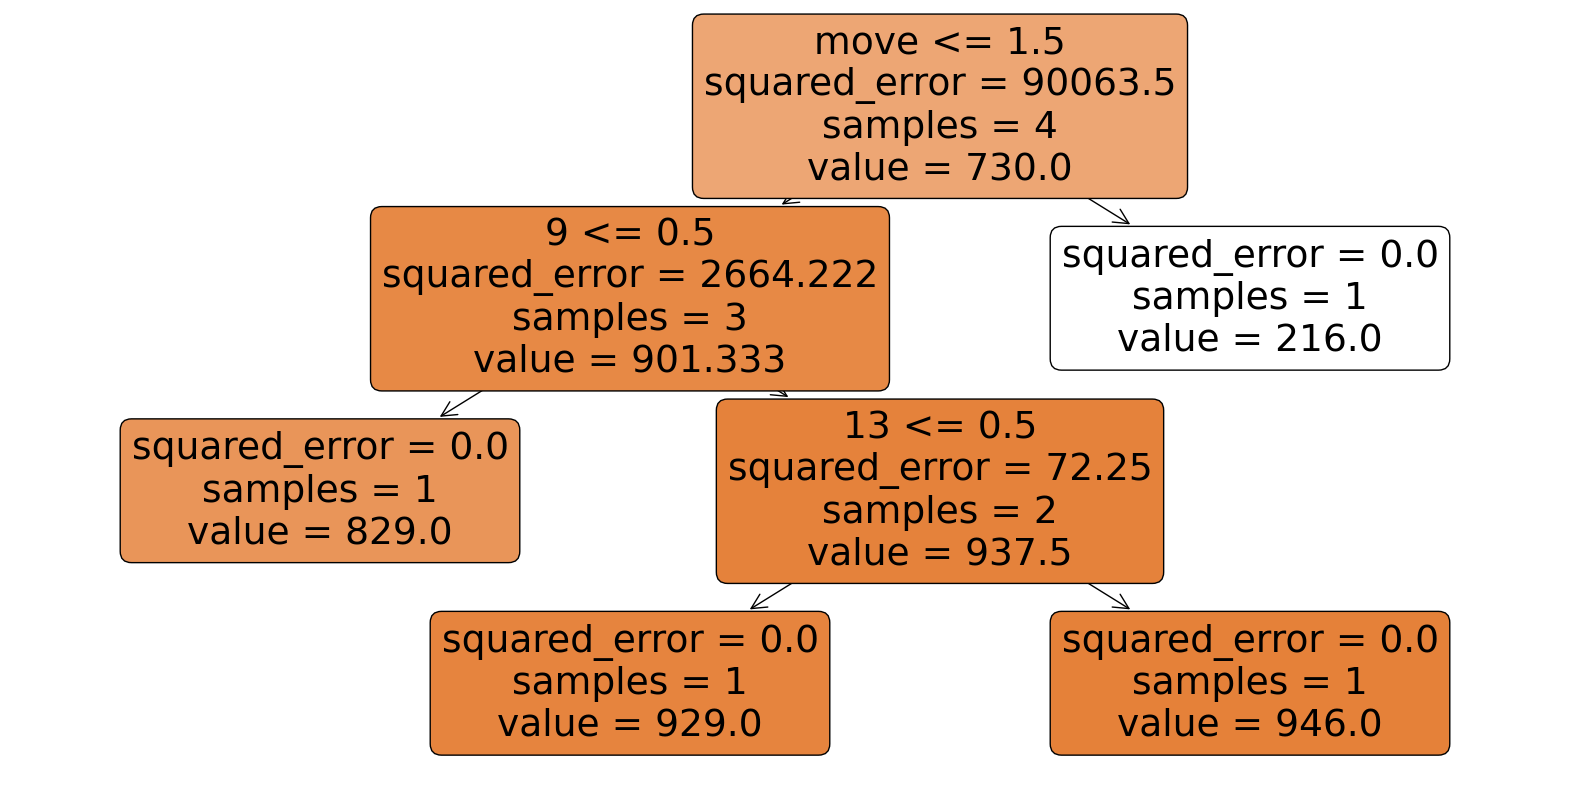

In [24]:

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Training the Decision Tree with a limited max_depth
dt_regressor = DecisionTreeRegressor(max_depth=3)  # Limiting the depth for better visualization
dt_regressor.fit(X_train, y_train)

# Plotting the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, filled=True, feature_names=X_train.columns, rounded=True)
plt.show()

   move  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  Actual_Score  \
1     1  1  0  1  0  0  0  1  1  0  1   1   1   0   0   0   0            90   

   Predicted_Score  
1            829.0  


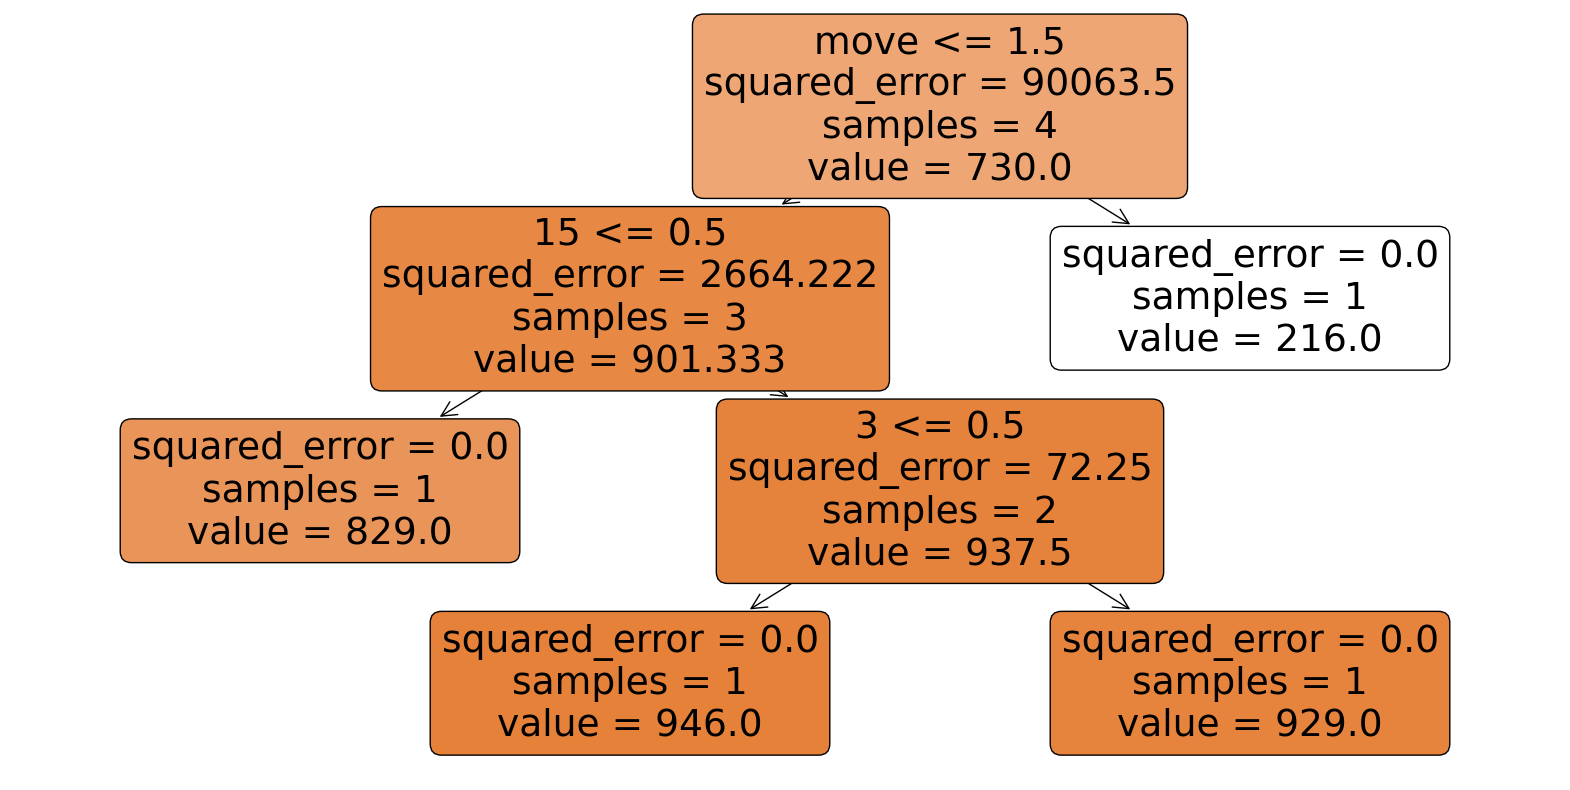

In [26]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Training the Decision Tree with a limited max_depth
dt_regressor = DecisionTreeRegressor(max_depth=3)  # Limiting the depth for better visualization
dt_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = dt_regressor.predict(X_test)

# Creating a DataFrame to display actual vs predicted scores
results = X_test.copy()
results['Actual_Score'] = y_test
results['Predicted_Score'] = y_pred

# Display the first few rows of the results
print(results.head())

# Plotting the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, filled=True, feature_names=X_train.columns, rounded=True)
plt.show()

   move  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  Actual_Score  \
1     1  1  0  1  0  0  0  1  1  0  1   1   1   0   0   0   0            90   

   Predicted_Score  
1            216.0  


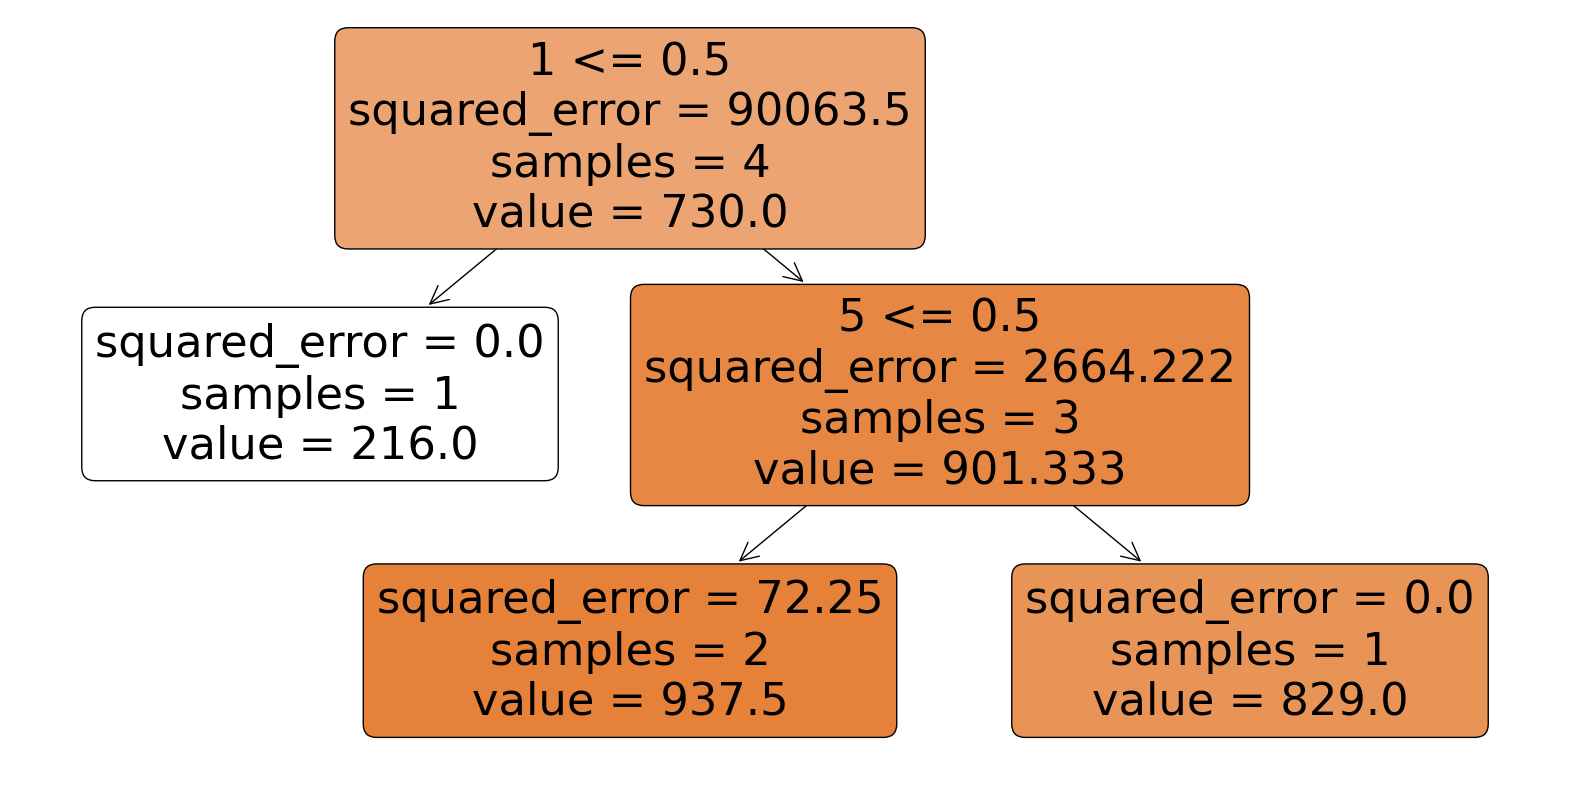

In [28]:

# Ensure all column names are strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Training the Decision Tree with a more limited max_depth
dt_regressor = DecisionTreeRegressor(max_depth=2)  # Further limiting the depth for better visualization
dt_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = dt_regressor.predict(X_test)

# Creating a DataFrame to display actual vs predicted scores
results = X_test.copy()
results['Actual_Score'] = y_test
results['Predicted_Score'] = y_pred

# Display the first few rows of the results
print(results.head())

# Plotting the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_regressor, filled=True, feature_names=X_train.columns, rounded=True)
plt.show()